<a href="https://colab.research.google.com/github/victormurcia/VCHAMPS/blob/main/VCHAMPS_Initial_EDA_and_Prototyping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# VCHAMPS EDA on Quality Check Dataset
*Made by Victor M. Murcia on 6/22/2023*

This notebook performs initial EDA on the various files that comprise the dataset provided for the VCHAMPS challenge hosted by precisionFDA found [here](https://precision.fda.gov/challenges/31).

I showcase routines to generate EDA reports and widgets that allow for rapid exploration and inspection of the various dataframes.

# Required Python Libraries and Modules
Below are the various libraries and modules I used to carry out this initial cursory analysis.

In [2]:
#General utilities
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib.lines import Line2D
import seaborn as sns
from tqdm import tqdm  # Import tqdm for the progress bar
import glob
import os
from typing import List
import warnings

#For Slider viz
import ipywidgets as widgets
from IPython.display import display, clear_output,HTML

#DataPrep for Quick EDA
!pip install dataprep
from dataprep.eda import create_report

#Enable data to be extracted and downloaded from my Google Drive
from google.colab import drive, files
drive.mount('/content/drive')

#For ML model stuff
from sklearn.datasets import load_iris,load_breast_cancer
from sklearn.model_selection import learning_curve, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_curve, roc_auc_score, confusion_matrix, log_loss
)
from sklearn.preprocessing import label_binarize
from sklearn.exceptions import ConvergenceWarning
import warnings

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 47.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.6/133.6 kB 15.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 53.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 59.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 37.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 764.0/764.0 kB 25.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 45.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 26.7 MB/s eta 0:00:00
  Created wheel for sqlalchemy: filename=SQLAlchemy-1.3.24-cp310-cp310-linux_x86_64.whl size=1268238 sha256=6b80c85bc6359a1d103dba2df63d680198ab22ea6d13709a8bb2797d59df077b
  Stored in directory: /root/

In [3]:
def load_csvs(path2data: str) -> List[str]:
  """
  Load and return a list of CSV file paths from the specified directory.

  Args:
      path2data (str): The directory path containing the CSV files.

  Returns:
      List[str]: A list of CSV file paths.

  """
  csv_files = glob.glob(path2data + '/*.csv')
  return csv_files

def make_df_list(csv_files: List[str]) -> List[pd.DataFrame]:
  """
  Read CSV files from the provided list of file paths and return a list of DataFrames.

  Args:
      csv_files (List[str]): A list of CSV file paths.

  Returns:
      List[pd.DataFrame]: A list of DataFrames read from the CSV files.

  """
  df_list = []
  # Read the CSV file
  for csv in csv_files:
    df = pd.read_csv(csv)
    df_list.append(df)

  return df_list

def clean_filenames(csv_files: List[str]) -> List[str]:
  """
  Clean the file names by removing directory path and the .csv extension.

  Args:
      csv_files (List[str]): A list of CSV file paths.

  Returns:
      List[str]: A list of cleaned file names without directory path and file extension.

  """
  #Get list of file names without directory junk and remove .csv extension from name
  file_names = []

  for file_path in csv_files:
      file_name = os.path.basename(file_path)  # Get the file name with extension
      file_name = os.path.splitext(file_name)[0]  # Remove the file extension
      file_names.append(file_name)
  return file_names

#Define data location
path2data = '/content/drive/MyDrive/Quality Check'
#Load the .csv files into memory
csv_files  = load_csvs(path2data)
#Create list of dataframes from csvs
df_list    = make_df_list(csv_files)
#Clean the names of .csv files
file_names = clean_filenames(csv_files)

# Widget for Rapid Dataframe Inspection
I made this widget to quickly inspect the generated dataframes from the provided .csv files. This allows us to quickly see all the different attributes present in the data.

In [37]:
def visualize_dataframes(df_list: List[pd.DataFrame], file_names: List[str]) -> None:
    """
    Visualizes a list of DataFrames with an interactive slider.

    Args:
        df_list (List[pd.DataFrame]): A list of pandas DataFrames to be visualized.
        file_names (List[str]): A list of corresponding file names for the DataFrames.

    Returns:
        None
    """
    # Set the maximum number of rows to be displayed
    pd.set_option("display.max_rows", 10)

    # Create an index slider
    index_slider = widgets.IntSlider(min=0, max=len(df_list)-1, value=0, description='DataFrame Index')

    # Function to display the selected dataframe
    output = widgets.Output()

    def display_dataframe(index: int) -> None:
        """
        Displays the selected DataFrame based on the index.

        Args:
            index (int): Index of the DataFrame to be displayed.

        Returns:
            None
        """
        df = df_list[index]
        current_file = file_names[index]
        with output:
            clear_output(wait=True)
            print('Filename: ',current_file)
            display(df)

    # Display the initial dataframe
    display(output)

    # Link the slider value to the display_dataframe function
    widgets.interactive_output(display_dataframe, {'index': index_slider})

    # Display the slider
    display(index_slider)

    # Link the slider value to the display_dataframe function
    widgets.interactive(display_dataframe, index=index_slider)

visualize_dataframes(df_list, file_names)

Output()

IntSlider(value=0, description='DataFrame Index', max=14)

# Widget for Rapid Extraction of Dataframe Information
This widget allows you to get a quick descrption of the dataframe composition son that you don't have to have multiple cells/calls to the df.info() method from pandas.

In [5]:
def show_dataframe_info_slider(df_list: List[pd.DataFrame], file_names: List[str]) -> None:
    """
    Display a slider to select a dataframe from the list and show its .info() method.

    Args:
        df_list (List[pd.DataFrame]): List of pandas DataFrames.
        file_names (List[str]): A list of corresponding file names for the DataFrames.

    Returns:
        None
    """
    def show_dataframe_info(index: int) -> None:
        """
        Display the .info() method for the selected dataframe.

        Args:
            index (int): Index of the dataframe to display info for.

        Returns:
            None
        """
        selected_df = df_list[index]
        current_file = file_names[index]
        with output:
            output.clear_output()
            print('Filename: ',current_file)
            selected_df.info()

    # Create the index slider
    index_slider = widgets.IntSlider(min=0, max=len(df_list)-1, value=0, description='DataFrame Index')

    # Output widget for displaying the .info() output
    output = widgets.Output()

    # Display the initial .info() output
    show_dataframe_info(index_slider.value)

    # Link the slider value to the show_dataframe_info function
    widgets.interactive_output(show_dataframe_info, {'index': index_slider})

    # Display the slider and output
    display(index_slider, output)

show_dataframe_info_slider(df_list, file_names)

IntSlider(value=0, description='DataFrame Index', max=14)

Output()

# Widget for Quick Inspection of Descriptive Statistics
This widget gives you the descriptive statistics for any numerical variables present in each of the dataframes via the .describe() method from pandas.

In [6]:
def show_dataframe_describe_slider(df_list: List[pd.DataFrame], file_names: List[str]) -> None:
    """
    Display a slider to select a dataframe from the list and show its .describe() method.

    Args:
        df_list (List[pd.DataFrame]): List of pandas DataFrames.
        file_names (List[str]): A list of corresponding file names for the DataFrames.

    Returns:
        None
    """
    def show_dataframe_describe(index: int) -> None:
        """
        Display the .describe() method for the selected dataframe.

        Args:
            index (int): Index of the dataframe to display describe for.

        Returns:
            None
        """
        selected_df = df_list[index]
        current_file = file_names[index]
        with output:
            output.clear_output()
            print('Filename: ',current_file)
            display(selected_df.describe())

    # Create the index slider
    index_slider = widgets.IntSlider(min=0, max=len(df_list)-1, value=0, description='DataFrame Index')

    # Output widget for displaying the .describe() output
    output = widgets.Output()

    # Display the initial .describe() output
    show_dataframe_describe(index_slider.value)

    # Link the slider value to the show_dataframe_describe function
    widgets.interactive_output(show_dataframe_describe, {'index': index_slider})

    # Display the slider and output
    display(index_slider, output)

show_dataframe_describe_slider(df_list, file_names)

IntSlider(value=0, description='DataFrame Index', max=14)

Output()

# Widget for Inspection of Categorical Variable in Dataframe
This widget will tell you the unique values and their counts for categorical variables for a given column in each dataframe. Use the slider to change the dataframe, and then use the dropdown menu to select the column you want information for.

In [7]:

def show_dataframe_column_info(df_list: List[pd.DataFrame], file_names: List[str], truncate_list: bool = True) -> None:
    """
    Display a slider to select a dataframe from the list, a dropdown menu to select columns,
    and show the unique() and value_counts() for the selected non-numerical column.

    Args:
        df_list (List[pd.DataFrame]): List of pandas DataFrames.
        file_names (List[str]): A list of corresponding file names for the DataFrames.
        truncate_list (bool): Flag to indicate whether to truncate the list of unique values. Default is True.

    Returns:
        None
    """
    def show_column_info(index: int, column: str) -> None:
        """
        Display the unique() and value_counts() for the selected non-numerical column of the selected dataframe.

        Args:
            index (int): Index of the dataframe.
            column (str): Name of the selected column.

        Returns:
            None
        """
        selected_df = df_list[index]
        current_file = file_names[index]
        with output:
            output.clear_output()
            print('Filename: ',current_file)
            non_numerical_columns = selected_df.select_dtypes(exclude='number').columns
            if column in non_numerical_columns:
                column_values = selected_df[column]
                unique_values = column_values.unique()
                value_counts = column_values.value_counts()

                # Truncate the list of unique values if truncate_list is True
                if truncate_list:
                    unique_values = unique_values[:10]

                print("Unique Values:")
                print(unique_values)
                print("\nValue Counts:")
                print(value_counts)
            else:
                print("Selected column is not non-numerical.")

    # Create the index slider
    index_slider = widgets.IntSlider(min=0, max=len(df_list)-1, value=0, description='DataFrame Index')

    # Create the column dropdown menu
    columns_dropdown = widgets.Dropdown(options=df_list[0].columns, description='Columns')

    # Output widget for displaying the column info
    output = widgets.Output()

    # Function to update the column options based on the selected dataframe
    def update_columns_options(change):
        columns_dropdown.options = df_list[index_slider.value].columns

    # Update the column options when the index slider changes
    index_slider.observe(update_columns_options, 'value')

    # Display the initial column info
    show_column_info(index_slider.value, columns_dropdown.value)

    # Link the slider and dropdown value to the show_column_info function
    widgets.interactive_output(show_column_info, {'index': index_slider, 'column': columns_dropdown})

    # Set the display.max_rows option based on the truncate_list flag
    if truncate_list:
        pd.set_option("display.max_rows", 10)
    else:
        pd.set_option("display.max_rows", None)

    # Display the slider, dropdown, and output
    display(index_slider, columns_dropdown, output)
show_dataframe_column_info(df_list, file_names,truncate_list = False)

IntSlider(value=0, description='DataFrame Index', max=14)

Dropdown(description='Columns', options=('Unnamed: 0', 'Internalpatientid', 'Ethnicity', 'Gender', 'Races', 'V…

Output()

# Generating EDA Reports
I'm using the dataprep to conduct the initial EDA to get a basic idea of the data we have available. The routine I made  below generates the EDA reports, saves them as .html files, and finally saves the generated reports into your local computer for easy viewing for each of the provided .csv files.

In [8]:
def df_eda_report(savepath: str, df_list: List[pd.DataFrame], file_names: List[str]):
    """
    Generate EDA reports for each DataFrame in df_list and save them as HTML files.

    Args:
        savepath (str): The directory path to save the generated HTML files.
        df_list (List[pd.DataFrame]): A list of DataFrames to generate reports for.
        file_names (List[str]): A list of desired names for the HTML files.

    Raises:
        FileNotFoundError: If the specified savepath directory does not exist.

    """
    if not os.path.exists(savepath):
        raise FileNotFoundError(f"The directory '{savepath}' does not exist.")

    i = 0
    for df in df_list:
        report = create_report(df, title='My Report')
        report.save()
        os.rename('report.html', os.path.join(savepath, file_names[i] + '.html'))
        i += 1

    html_files = glob.glob(os.path.join(savepath, '*.html'))
    for file in html_files:
        files.download(file)

#df_eda_report(savepath)

<Axes: ylabel='Frequency'>

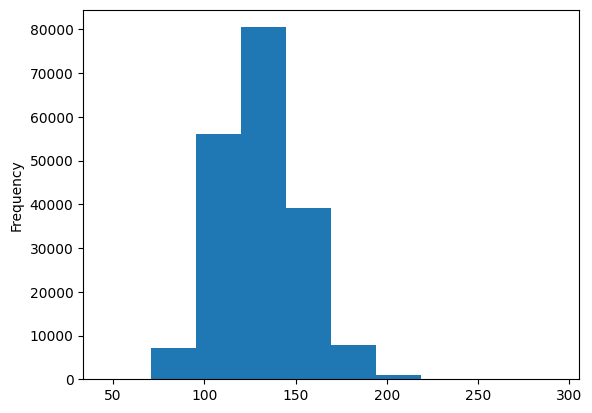

In [9]:
df_list[4]['Systolic bp'].plot.hist()

# Dataframe Transformations for Tidying
None of the provided datasets are in tidy format (i.e., there are multiple observations for the same patient across multiple rows). We'll need change this in order to train our models.

I started working on this and it still needs work,however, it'll require something along the lines of a combination of pivoting and flattening transformations as shown below.

The resulting dataframe is now tidy, however, we also now have hundreds of new features. We'll need to do some feature engineering prior to carrying out this transformation effectively.

In [10]:
pd.set_option("display.max_rows", 10)
# Use pivot_table to group observations by Internalpatientid
pivot_df = pd.pivot_table(df_list[1].drop('Unnamed: 0', axis=1), index='Internalpatientid', columns=['Specialty'], aggfunc='first')
flattened = pd.DataFrame(pivot_df.to_records())
flattened.columns = [hdr.replace("('Age at specialty', ", "Age").replace(")", "").replace("(", "") \
                     for hdr in flattened.columns]
flattened.columns = [hdr.replace("('State', ", "State").replace(")", "").replace("(", "") \
                     for hdr in flattened.columns]
flattened

,Internalpatientid,Age'ACUTE PSYCHIATRY <45 DAYS',Age'ALCOHOL DEPENDENCE TRMT UNIT',Age'ALLERGY',Age'ANESTHESIOLOGY',Age'BLIND REHAB',Age'BLIND REHAB OBSERVATION',Age'CARDIAC INTENSIVE CARE UNIT',Age'CARDIAC SURGERY',Age'CARDIAC-STEP DOWN UNIT',...,"'State', 'SURGICAL ICU'","'State', 'SURGICAL OBSERVATION'","'State', 'SURGICAL STEPDOWN'","'State', 'TELEMETRY'","'State', 'THORACIC SURGERY'","'State', 'TRANSPLANTATION'","'State', 'UROLOGY'","'State', 'VASCULAR'","'State', 'ZZALCOHOL DEPENDENCE TRMT UNIT'","'State', 'ZZSUBSTANCE ABUSE INTERMEDCARE'"
0,67,NaN,NaN,56.997988,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,200,NaN,NaN,84.145147,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Utah,NaN,NaN,NaN
2,291,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,330,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,351,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
627,166881,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
628,167102,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64.047944,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
629,167404,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
630,167917,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Pennsylvania,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
flattened.columns

Index(['Internalpatientid', 'Age'ACUTE PSYCHIATRY <45 DAYS'',
       'Age'ALCOHOL DEPENDENCE TRMT UNIT'', 'Age'ALLERGY'',
       'Age'ANESTHESIOLOGY'', 'Age'BLIND REHAB'',
       'Age'BLIND REHAB OBSERVATION'', 'Age'CARDIAC INTENSIVE CARE UNIT'',
       'Age'CARDIAC SURGERY'', 'Age'CARDIAC-STEP DOWN UNIT'',
       ...
       ''State', 'SURGICAL ICU'', ''State', 'SURGICAL OBSERVATION'',
       ''State', 'SURGICAL STEPDOWN'', ''State', 'TELEMETRY'',
       ''State', 'THORACIC SURGERY'', ''State', 'TRANSPLANTATION'',
       ''State', 'UROLOGY'', ''State', 'VASCULAR'',
       ''State', 'ZZALCOHOL DEPENDENCE TRMT UNIT'',
       ''State', 'ZZSUBSTANCE ABUSE INTERMEDCARE''],
      dtype='object', length=469)

In [12]:
# Use pivot_table to group observations by Internalpatientid
pivot_df = pd.pivot_table(df_list[1].drop('Unnamed: 0', axis=1), index='Internalpatientid', columns=['Specialty'], aggfunc='first')
pivot_df.columns = pivot_df.columns.droplevel(0)
pivot_df.columns.name = None
pivot_df.reset_index()
pivot_df

,ACUTE PSYCHIATRY (<45 DAYS),ALCOHOL DEPENDENCE TRMT UNIT,ALLERGY,ANESTHESIOLOGY,BLIND REHAB,BLIND REHAB OBSERVATION,CARDIAC INTENSIVE CARE UNIT,CARDIAC SURGERY,CARDIAC-STEP DOWN UNIT,CARDIOLOGY,...,SURGICAL ICU,SURGICAL OBSERVATION,SURGICAL STEPDOWN,TELEMETRY,THORACIC SURGERY,TRANSPLANTATION,UROLOGY,VASCULAR,ZZALCOHOL DEPENDENCE TRMT UNIT,ZZSUBSTANCE ABUSE INTERMEDCARE
Internalpatientid,,,,,,,,,,,,,,,,,,,,,
67,NaN,NaN,56.997988,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
200,NaN,NaN,84.145147,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Utah,NaN,NaN,NaN
291,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
330,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
351,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166881,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
167102,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64.047944,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
167404,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
pivot_df.columns

Index(['ACUTE PSYCHIATRY (<45 DAYS)', 'ALCOHOL DEPENDENCE TRMT UNIT',
       'ALLERGY', 'ANESTHESIOLOGY', 'BLIND REHAB', 'BLIND REHAB OBSERVATION',
       'CARDIAC INTENSIVE CARE UNIT', 'CARDIAC SURGERY',
       'CARDIAC-STEP DOWN UNIT', 'CARDIOLOGY',
       ...
       'SURGICAL ICU', 'SURGICAL OBSERVATION', 'SURGICAL STEPDOWN',
       'TELEMETRY', 'THORACIC SURGERY', 'TRANSPLANTATION', 'UROLOGY',
       'VASCULAR', 'ZZALCOHOL DEPENDENCE TRMT UNIT',
       'ZZSUBSTANCE ABUSE INTERMEDCARE'],
      dtype='object', length=468)

#GitHub repository for Project
I made a GitHub repository to maintain the code. You can find that repository [here](https://github.com/victormurcia/VCHAMPS).
## Git Basics
1. To download files from the repository, open up a terminal and clone the repository into your local machine via
```
git clone https://github.com/victormurcia/VCHAMPS.git
```

2. Navigate to the repository in your local machine via
```
cd VCHAMPS
```

3. Now you can make whatever changes you want in your local system to those files.

For example, I mistakenly uploaded the Quality Check EDA Reports into the wrong folder. To correct that I wrote a quick PowerShell script to move all files in the initial folder to a desired folder as shown below.
```
Get-ChildItem 'C:\Users\vmurc\Desktop\VCHAMPS\Quality Check\' -File | ForEach-Object {
  Move-Item -Path $_.FullName -Destination'C:\Users\vmurc\Desktop\VCHAMPS\Quality Check\EDA\'
}
```

4. After you've made changes to the file(s) in the repository you can now stage the changes into the branch via

```
git add .
```

5. Next, you'll want to commit the changes via
```
git commit -m "Moved files to new location"
```

6. Finally, push the changes to the remote repository:

```
git push origin main
```

# Notes on Time Formats
There are seemingly two different time formats present across all dataframes

# FAQs

1. What exactly is considered a hospital readmission for the challenge? What specific data do we need to consider when counting 'hospital readmissions' and is there any time window to consider?

Answer: For the purposes of this Challenge, any 2 admissions for a subject over any period of time is considered a readmission.

Hospital admission and hospital readmission refer only to hospitalizations (i.e., inpatient visits).

Outpatient encounters (including ED visits and clinic encounters) are not counted as a hospital admission or readmission; however, they may be considered separately as outcomes of interest.

Teams are also encouraged to analyze readmissions at 30, 60, 90, 180, and/or 365 days to understand model prediction for heart failure outcomes.

2. What is the definition for CV/all-cause hospitalization?

Answer: Only being admitted or readmitted to the hospital is what counts as an “admission” and that is what we refer to in terms of determining all-cause and CV hospital admission.

3. What is the definition for mortality?

Answer: In-hospital mortality events (all cause and CV) are confirmed during the hospitalization. Primary and secondary coded diagnoses during the hospitalization which resulted in death are provided. Mortality events outside the hospital are also provided; however, the reliability of the reported cause of death can be variable in these situations.

4. What is the definition for CV diagnoses?

Answer: Cardiovascular causes are defined as a coded diagnosis (first listed discharge diagnosis and/or second listed discharge diagnosis) including the following:

* Systolic (congestive) heart failure
* Diastolic (congestive) heart failure
* Heart failure (unspecified)Other heart failure
* Combined systolic (congestive) and diastolic (congestive) heart failure
* Cardiogenic shock
* Hypertensive heart disease with heart failure
* Hypertensive heart and kidney disease with heart failure
* ST elevation (STEMI) myocardial infarction
* Non-ST elevation (NSTEMI) myocardial infarction
* Unstable angina
* Other forms of chronic ischemic heart disease
* Atherosclerotic heart disease of native coronary artery
* Atrial fibrillation
* Atrial flutter
* Supraventricular tachycardia
* Ventricular tachycardia

5. How are comorbidities defined in the synthetic data set?

Answer: Comorbidities are multiple coexisting diseases or conditions, and can be determined by evaluating if the synthetic chronic heart failure patient is also being tracked for any other disease, e.g., by looking at the first listed discharge diagnosis and the second listed discharge diagnosis in the inpatient data.

6. Some of the death dates appear to be in the future. How is that possible?

Answer: The synthetic data lake algorithm uses date shifting to enable privacy. As a result, there are dates in the future and past in the synthetic data set that are not present in the original clinical data set.

7. Some of the outpatient visits (or encounters) appear to be after the synthetic patient has died. How is that possible?

Answer: In some cases, you may find outpatient encounters listed after the patient has died. These outpatient encounters are visits that were scheduled prior to death and had not been cancelled.

8. What needs to be submitted?

Two CSV files corresponding to predictions made for each synthetic Veteran: a) in the test data set, and b) in the quality check data set. Please note that values for Tier 1 and Tier 2 metrics need to be provided in double precision and will only be included in the test data set csv.
Model card providing details about their algorithm (preferably in word format; we will not accept PDF files for submissions).
Scripts/code (See model script section below)


# Calculating Confidence Scores
The model we are building will predict a binary outcome (0 or 1) depending on whether the patient lives or dies. However, we are also required to provide a continuous confidence score (a number between 0 and 1) which represents the a probability estimate that an instance (e.g., an image, a text snippet, etc.) belongs to a specific class.

This can be done rather simply thanks to prebuilt functions in sklearn. I'll show a quick example of how to do it on a binary classification problem using the classic breast_cancer dataset trained with a Logistic Regression classifier model as shown below

In [14]:
# Load the breast cancer dataset
data = load_breast_cancer()
X, y = data.data, data.target

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train a model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Get the normalized confidence scores
confidence_scores = model.predict_proba(X_test)

#Checks if the number is larger than 0.01 and, if so, it formats it as a decimal with 2 digits after the decimal point.
#Otherwise, it uses scientific notation with 2 significant digits.
pd.options.display.float_format = lambda x : '{:.2f}'.format(x) if x > 0.01 else '{:.2e}'.format(x)

# Convert confidence_scores to a DataFrame
confidence_df = pd.DataFrame(confidence_scores, columns=['Prob_class_0', 'Prob_class_1'])
confidence_df

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,Prob_class_0,Prob_class_1
0,0.17,0.83
1,1.00,3.24e-09
2,1.00,1.74e-03
3,2.92e-03,1.00
4,6.38e-04,1.00
...,...,...
109,0.11,0.89
110,1.00,2.77e-04
111,3.09e-03,1.00
112,0.78,0.22


Here's a quick example of how to do it on a multiclass classification problem using the classic iris dataset trained with a Logistic Regression classifier model as shown below

In [15]:
# Load the iris dataset
iris = load_iris()
X, y = iris.data, iris.target

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train a model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Get the normalized confidence scores
confidence_scores = model.predict_proba(X_test)

# Convert confidence_scores to a DataFrame
confidence_df = pd.DataFrame(confidence_scores, columns=iris.target_names)

confidence_df

,setosa,versicolor,virginica
0,3.79e-03,0.83,0.17
1,0.95,0.05,2.00e-07
2,8.72e-09,1.56e-03,1.00
3,6.43e-03,0.79,0.20
4,1.44e-03,0.77,0.22
...,...,...,...
25,9.33e-05,0.11,0.89
26,8.69e-06,0.06,0.94
27,4.30e-06,0.02,0.98
28,0.97,0.03,1.36e-07


# Assessing Model Performance

Learning curves can help in determining if a model is on the correct learning trajectory of achieving the bias-variance tradeoff. It also provides a basis for comparing different machine learning models – a model with stable learning curves across both training and validation sets is likely going to perform well over a longer period on unseen data (i.e., gauge model generalizability).

Bias is the assumption used by machine learning models to make the learning process easier. Variance is the measure of how much the estimated target variable will change with a change in training data. The ultimate goal is to reduce both bias and variance to a minimum – a state of high stability with few assumptions.

Bias and variance are indirectly proportional to each other, and the only way to reach a minimum point for both is at the intersection point. One way to understand if a model has achieved a significant level of trade-off is to see if its performance across training and testing datasets is nearly similar.

The best way to track the progress of model training is to use learning curves. These curves help to identify the optimal combinations of hyperparameters and assists massively in model selection and model evaluation. Typically, a learning curve is a way to track the learning or improvement in model performance on the y-axis and the time or experience on the x-axis.

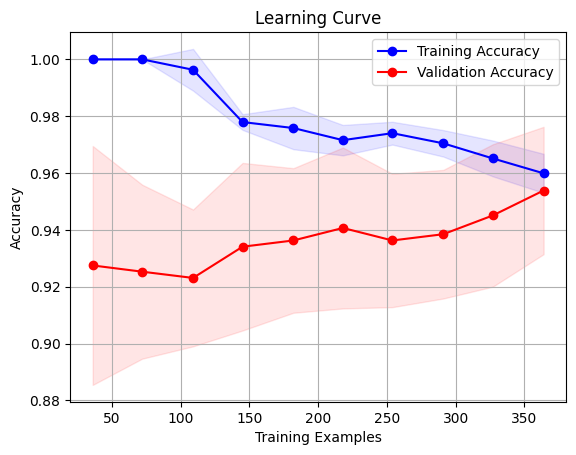

In [16]:
def generate_learning_curves(X, y, classifier):
    """
    Generates learning curves to assess model performance over varying training set sizes.

    Parameters:
    - X (array-like): The input features.
    - y (array-like): The target variable.
    - classifier: The classification model.
    """
    train_sizes, train_scores, validation_scores = learning_curve(
        classifier, X, y, train_sizes=np.linspace(0.1, 1.0, 10), cv=5, scoring='accuracy'
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    validation_scores_mean = np.mean(validation_scores, axis=1)
    validation_scores_std = np.std(validation_scores, axis=1)

    plt.figure()
    plt.title("Learning Curve")
    plt.xlabel("Training Examples")
    plt.ylabel("Accuracy")
    plt.grid()
    plt.fill_between(
        train_sizes, train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std, alpha=0.1, color="b"
    )
    plt.fill_between(
        train_sizes, validation_scores_mean - validation_scores_std,
        validation_scores_mean + validation_scores_std, alpha=0.1, color="r"
    )
    plt.plot(train_sizes, train_scores_mean, 'o-', color="b", label="Training Accuracy")
    plt.plot(train_sizes, validation_scores_mean, 'o-', color="r", label="Validation Accuracy")
    plt.legend(loc="best")
    plt.show()

def calculate_classification_metrics(y_true, y_pred, y_prob):
    """
    Calculates various classification metrics for evaluating model performance.

    Parameters:
    - y_true (array-like): The true target values.
    - y_pred (array-like): The predicted target values.
    - y_prob (array-like): The predicted probabilities for the positive class.

    Returns:
    - metrics_df (DataFrame): DataFrame containing the calculated metrics.
    """
    accuracy = accuracy_score(y_true, y_pred)
    logloss = log_loss(y_true, y_prob)

    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    confusion_mat = confusion_matrix(y_true, y_pred)
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    roc_auc = roc_auc_score(y_true, y_prob)

    metrics_df = pd.DataFrame({
        'Accuracy': [accuracy],
        'Log Loss': [logloss],
        'Precision': [precision],
        'Recall': [recall],
        'F1 Score': [f1],
        'ROC AUC': [roc_auc]
    })

    return metrics_df

# Load the breast cancer dataset
breast_cancer = load_breast_cancer()
X, y = breast_cancer.data, breast_cancer.target

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a logistic regression classifier
classifier = LogisticRegression(max_iter=1000, solver='lbfgs')

# Filter out the convergence warning messages
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning)

    # Generate learning curves
    generate_learning_curves(X_train, y_train, classifier)

    # Train the classifier
    classifier.fit(X_train, y_train)

    # Make predictions and obtain predicted probabilities on the test set
    y_pred = classifier.predict(X_test)
    y_prob = classifier.predict_proba(X_test)[:, 1]

    # Calculate classification metrics
    metrics_df = calculate_classification_metrics(y_test, y_pred, y_prob)

# Determining Median Time of Readmission

For the purposes of this Challenge, any 2 admissions for a subject over any period of time is considered a readmission. Hospital admission and hospital readmission refer only to hospitalizations (i.e., inpatient visits). Teams are also encouraged to analyze readmissions at 30, 60, 90, 180, and/or 365 days to understand model prediction for heart failure outcomes.


In [17]:
visualize_dataframes(df_list, file_names)

Output()

IntSlider(value=0, description='DataFrame Index', max=14)

The 'inpatient_specialty_qual.csv' dataframe is likely to be the one containing the most useful readmission information.

In [18]:
inpatient_specialty_qual_df = df_list[1]
#Convert dates to datetime data types for proper parsing
inpatient_specialty_qual_df['Specialty start date'] = pd.to_datetime(inpatient_specialty_qual_df['Specialty start date'])
inpatient_specialty_qual_df['Specialty end date'] = pd.to_datetime(inpatient_specialty_qual_df['Specialty end date'])
inpatient_specialty_qual_df

,Unnamed: 0,Internalpatientid,Age at specialty,Specialty start date,Specialty end date,Specialty,State
0,266,100399,84.47,2008-12-27 22:00:08,2009-01-01 01:41:45,"PULMONARY, NON-TB",Minnesota
1,267,100399,85.55,2010-01-27 00:58:53,2010-02-03 20:55:56,SUBSTANCE ABUSE TRMT UNIT,Minnesota
2,268,100399,86.34,2010-11-09 14:50:30,2010-11-10 17:47:52,SURGICAL OBSERVATION,Minnesota
3,416,100694,72.49,2004-08-04 12:53:09,2004-08-07 14:21:19,SURGICAL STEPDOWN,Idaho
4,1535,102468,59.68,2011-04-08 21:39:44,2011-04-12 23:58:20,GEM ACUTE MEDICINE,North Carolina
...,...,...,...,...,...,...,...
11384,1850213,98416,73.04,2000-09-25 13:53:23,2000-09-26 05:09:15,HALFWAY HOUSE,California
11385,1850214,98416,78.02,2005-09-18 18:45:38,2005-09-18 18:45:38,CARDIOLOGY,California
11386,1850598,99024,68.29,2014-08-25 10:16:36,2014-08-25 10:16:36,GENERAL(ACUTE MEDICINE),Oregon
11387,1850779,9929,72.79,2011-11-05 03:15:59,2011-11-07 03:15:58,ANESTHESIOLOGY,Arizona


In [19]:
#Check that datetime conversion was succesful
inpatient_specialty_qual_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11389 entries, 0 to 11388
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Unnamed: 0            11389 non-null  int64         
 1   Internalpatientid     11389 non-null  int64         
 2   Age at specialty      11389 non-null  float64       
 3   Specialty start date  11389 non-null  datetime64[ns]
 4   Specialty end date    11386 non-null  datetime64[ns]
 5   Specialty             11389 non-null  object        
 6   State                 11389 non-null  object        
dtypes: datetime64[ns](2), float64(1), int64(2), object(2)
memory usage: 623.0+ KB


In [20]:
#Calculate duration of stay at a given unit
inpatient_specialty_qual_df['Duration (hours)'] = (inpatient_specialty_qual_df['Specialty end date'] - inpatient_specialty_qual_df['Specialty start date']).dt.total_seconds() / 3600
inpatient_specialty_qual_df

,Unnamed: 0,Internalpatientid,Age at specialty,Specialty start date,Specialty end date,Specialty,State,Duration (hours)
0,266,100399,84.47,2008-12-27 22:00:08,2009-01-01 01:41:45,"PULMONARY, NON-TB",Minnesota,99.69
1,267,100399,85.55,2010-01-27 00:58:53,2010-02-03 20:55:56,SUBSTANCE ABUSE TRMT UNIT,Minnesota,187.95
2,268,100399,86.34,2010-11-09 14:50:30,2010-11-10 17:47:52,SURGICAL OBSERVATION,Minnesota,26.96
3,416,100694,72.49,2004-08-04 12:53:09,2004-08-07 14:21:19,SURGICAL STEPDOWN,Idaho,73.47
4,1535,102468,59.68,2011-04-08 21:39:44,2011-04-12 23:58:20,GEM ACUTE MEDICINE,North Carolina,98.31
...,...,...,...,...,...,...,...,...
11384,1850213,98416,73.04,2000-09-25 13:53:23,2000-09-26 05:09:15,HALFWAY HOUSE,California,15.26
11385,1850214,98416,78.02,2005-09-18 18:45:38,2005-09-18 18:45:38,CARDIOLOGY,California,0.00e+00
11386,1850598,99024,68.29,2014-08-25 10:16:36,2014-08-25 10:16:36,GENERAL(ACUTE MEDICINE),Oregon,0.00e+00
11387,1850779,9929,72.79,2011-11-05 03:15:59,2011-11-07 03:15:58,ANESTHESIOLOGY,Arizona,48.00


In [21]:
inpatient_specialty_qual_df.nunique()

Unnamed: 0              11389
Internalpatientid         632
Age at specialty        11389
Specialty start date    11313
Specialty end date      11373
Specialty                 117
State                      49
Duration (hours)         7288
dtype: int64

In [22]:
# Group the dataframe by 'Internalpatientid' and count the number of unique 'Specialty start date' values
unique_start_dates = inpatient_specialty_qual_df.groupby('Internalpatientid')['Specialty start date'].nunique().reset_index()

# Rename the column to 'Number of unique start dates'
unique_start_dates.rename(columns={'Specialty start date': 'Number of unique start dates'}, inplace=True)

unique_start_dates

,Internalpatientid,Number of unique start dates
0,67,2
1,200,15
2,291,22
3,330,15
4,351,16
...,...,...
627,166881,4
628,167102,9
629,167404,3
630,167917,14


In [23]:
# Calculate the median of the 'Number of unique start dates' column
unique_start_dates['Number of unique start dates'].median()

11.0

In [24]:
unique_start_dates['Number of unique start dates'].describe()

count   632.00
mean     17.90
std      22.81
min       2.00
25%       5.00
50%      11.00
75%      22.00
max     303.00
Name: Number of unique start dates, dtype: float64

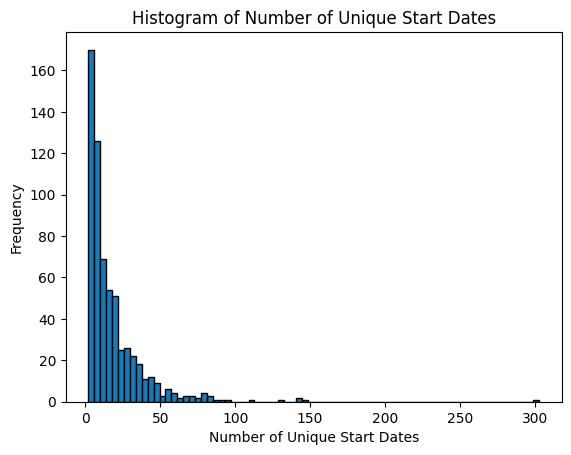

In [25]:
# Plot the histogram
plt.hist(unique_start_dates['Number of unique start dates'], bins='auto', edgecolor='black')
# Set the labels and title
plt.xlabel('Number of Unique Start Dates')
plt.ylabel('Frequency')
plt.title('Histogram of Number of Unique Start Dates')
# Display the histogram
plt.show()

Number of modes in the distribution: 12


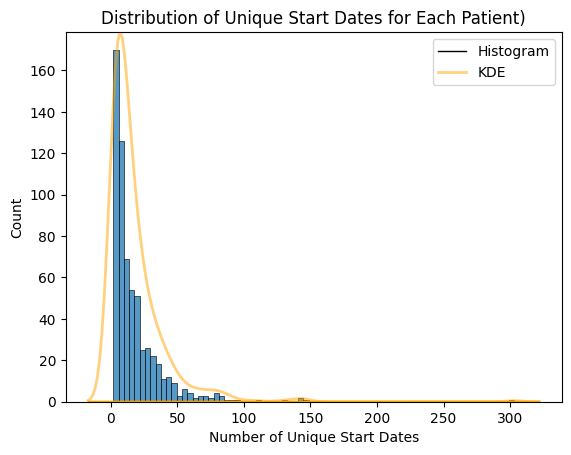

In [26]:
# Plot the histogram
hist = sns.histplot(unique_start_dates['Number of unique start dates'], bins='auto')

# Get the maximum value from the histogram
hist_max = hist.get_ylim()[1]

# Plot the KDE curve and adjust the weights
kdeplot = sns.kdeplot(unique_start_dates['Number of unique start dates'], color='orange', linewidth=2, alpha=0.5,)
kdeplot.lines[0].set_ydata(kdeplot.lines[0].get_ydata() * hist_max / np.max(kdeplot.lines[0].get_ydata()))

# Set the labels and title
plt.xlabel('Number of Unique Start Dates')
plt.ylabel('Count')
plt.title('Distribution of Unique Start Dates for Each Patient)')

# Create a custom legend
legend_elements = [Line2D([0], [0], color='black', lw=1, label='Histogram'),
                   Line2D([0], [0], color='orange', lw=2, alpha=0.5, label='KDE')]
plt.legend(handles=legend_elements)

# Identify the number of peaks or modes
peaks = sns.kdeplot(unique_start_dates['Number of unique start dates'], color='orange').get_lines()[0].get_data()[1]
num_modes = len([peak for peak in peaks if peak > 100])

# Print the number of modes
print("Number of modes in the distribution:", num_modes)

# Display the histogram with KDE
plt.show()

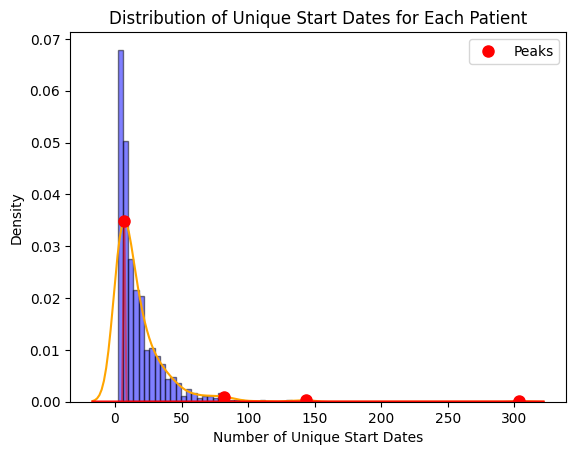

In [27]:
from scipy.signal import find_peaks_cwt

# Set the figure and axes
fig, ax = plt.subplots()

# Plot the KDE curve
kde = sns.kdeplot(unique_start_dates['Number of unique start dates'], color='orange', ax=ax)

# Set the labels and title
ax.set_xlabel('Number of Unique Start Dates')
ax.set_ylabel('Density')
ax.set_title('Distribution of Unique Start Dates for Each Patient')

# Get the data points of the KDE curve
x, y = kde.get_lines()[0].get_data()

# Find the peaks in the KDE curve
peaks = find_peaks_cwt(y, np.arange(1, 6))  # Adjust the widths parameter as needed

# Plot the Gaussian lineshape for each detected peak
for peak_idx in peaks:
    peak_x = x[peak_idx]
    peak_y = y[peak_idx]
    component = np.exp(-0.5 * ((x - peak_x) / peak_y) ** 2)
    ax.plot(x, component * peak_y, 'r-', linewidth=1.5, alpha=0.5)

# Plot the points indicating the peak locations
ax.plot(x[peaks], y[peaks], 'ro', markersize=8, label='Peaks')

# Plot the histogram
ax.hist(unique_start_dates['Number of unique start dates'], bins='auto', alpha=0.5, color='blue', density=True, edgecolor='black')

# Set the y-axis limits to match the maximum of either the KDE curve or the histogram
#ax.set_ylim(0, max(max(y), ax.get_ylim()[1]))

# Display the legend
ax.legend()

# Display the KDE plot with detected peaks represented as Gaussian lineshapes and the histogram
plt.show()

Huh? Some patients have over 100 readmissions? Let me take a closer look

In [28]:
# Create a new dataframe with rows where 'Number of unique start dates' is over 100
filtered_df = unique_start_dates[unique_start_dates['Number of unique start dates'] > 100]
filtered_df

,Internalpatientid,Number of unique start dates
76,21909,130
224,61719,145
275,76555,303
308,84413,141
428,115142,109
513,135216,143


Interesting. One of the patients has over 300 readmissions

In [29]:
# Specify the 'Internalpatientid' for which you want to filter the observations
specific_patient_id = 76555

# Create a new dataframe with observations for the specific 'Internalpatientid'
patient_id_df = inpatient_specialty_qual_df[inpatient_specialty_qual_df['Internalpatientid'] == specific_patient_id]
patient_id_df

,Unnamed: 0,Internalpatientid,Age at specialty,Specialty start date,Specialty end date,Specialty,State,Duration (hours)
7746,1289760,76555,57.35,2000-11-19 01:29:11,2000-11-19 01:29:11,GEN INTERMEDIATE PSYCH,Michigan,0.00e+00
7747,1289761,76555,63.17,2006-09-14 21:17:00,2006-09-15 07:50:48,MEDICAL OBSERVATION,Michigan,10.56
7748,1289762,76555,63.18,2006-09-18 07:59:44,2006-09-18 07:59:44,GENERAL(ACUTE MEDICINE),Michigan,0.00e+00
7749,1289763,76555,64.46,2008-01-01 10:10:44,2008-01-01 10:10:44,INTERMEDIATE MEDICINE,Michigan,0.00e+00
7750,1289764,76555,64.88,2008-05-30 23:17:25,2008-06-13 15:40:24,VASCULAR,Michigan,328.38
...,...,...,...,...,...,...,...,...
11074,1802516,76555,64.65,2008-03-07 19:49:15,2008-03-09 18:19:20,MEDICAL OBSERVATION,Michigan,46.50
11075,1802517,76555,66.27,2009-10-21 22:46:26,2009-11-02 07:01:42,CARDIAC INTENSIVE CARE UNIT,Michigan,272.25
11076,1802518,76555,66.76,2010-04-18 18:05:12,2010-04-18 18:05:12,GEN INTERMEDIATE PSYCH,Michigan,0.00e+00
11077,1802519,76555,71.11,2014-08-28 02:28:45,2014-08-28 11:28:44,CARDIAC INTENSIVE CARE UNIT,Michigan,9.00


# Fraction of patients that experience mortality event while in hospital
This would be assessed via the 'Died at location' column in 'inpatient_location_qual.csv'. Unfortunately, this column is completely empty. So either the mortality event was not recorded (which seems unlikely) or none of the patients experienced a mortality event.

In [30]:
inpatient_location_qual_df = df_list[6]
inpatient_location_qual_df

,Unnamed: 0,Internalpatientid,Age at location,Location start date,Location end date,Service,Died at location,State
0,3,100012,53.97,01:36.0,00:09.0,MEDICINE,NaN,New Mexico
1,4,100012,58.15,15:29.0,48:41.0,SURGERY,NaN,New Mexico
2,145,100399,85.82,04:13.0,34:12.0,NHCU,NaN,Minnesota
3,146,100399,86.18,02:21.0,22:24.0,NHCU,NaN,Minnesota
4,147,100399,86.33,00:51.0,44:08.0,NHCU,NaN,Minnesota
...,...,...,...,...,...,...,...,...
7038,1083562,98416,77.30,31:05.0,01:52.0,MEDICINE,NaN,California
7039,1083563,98416,77.31,59:38.0,28:12.0,MEDICINE,NaN,California
7040,1083564,98416,78.00,59:50.0,12:15.0,MEDICINE,NaN,California
7041,1083940,9929,72.40,36:31.0,27:10.0,MEDICINE,NaN,Arizona


In [31]:
inpatient_location_qual_df.nunique()

Unnamed: 0             7043
Internalpatientid       632
Age at location        6947
Location start date    3072
Location end date      3038
Service                  12
Died at location          0
State                    49
dtype: int64

# Finding most common dosages in Lab Results
Make a regex for it

In [32]:
lab_results_df = df_list[11]
lab_results_df

,Unnamed: 0,Internalpatientid,Age at lab test,Lab test date,Lab test,Lab test description,Result numeric,Result textual,Result range,Result units,Specimen source,State
0,10813,100012,53.09,2002-08-01 21:31:49.0,potassium_mmol/l_plasma,POTASSIUM,3.44,NaN,3.5 - 4.8,mmol/L,plasma,New Mexico
1,10814,100012,53.09,2002-08-01 21:31:49.0,urea nitrogen_mg/dl_plasma,UREA NITROGEN,24.00,NaN,7 - 20,mg/dL,plasma,New Mexico
2,10815,100012,53.09,2002-08-01 21:31:49.0,creatinine_mg/dl_plasma,CREATININE,1.14,NaN,.8 - 1.6,mg/dL,plasma,New Mexico
3,10816,100012,53.09,2002-08-01 21:31:49.0,magnesium_mg/dl_plasma,MAGNESIUM,2.26,NaN,1.6 - 2.4,mg/dL,plasma,New Mexico
4,10817,100012,53.09,2002-08-01 21:31:49.0,albumin_g/dl_plasma,ALBUMIN,3.90,NaN,3.5 - 4.8,g/dL,plasma,New Mexico
...,...,...,...,...,...,...,...,...,...,...,...,...
1970526,328841152,51551,60.91,2015-07-30 17:50:06.0,absolute lymphocyte count_k/cmm_blood,ABSOLUTE LYMPHOCYTE COUNT,1.25,NaN,.8 - 5.6,K/cmm,blood,Ohio
1970527,328841153,51551,60.91,2015-07-30 17:50:06.0,absolute basophil count_k/cmm_blood,ABSOLUTE BASOPHIL COUNT,0.09,NaN,0 - .3,K/cmm,blood,Ohio
1970528,328841154,51551,60.91,2015-07-30 17:50:06.0,hgb_g/dl_blood,Hgb,13.85,NaN,13.6 - 17.4,g/dL,blood,Ohio
1970529,328841155,51551,60.91,2015-08-01 01:58:13.0,ptt_sec_plasma,PTT,65.00,NaN,26 - 36,Sec,plasma,Ohio


In [33]:
lab_results_df.nunique()

Unnamed: 0           1970531
Internalpatientid        983
Age at lab test      1970465
Lab test date         288588
Lab test               29706
                      ...   
Result textual          2982
Result range            8665
Result units            1266
Specimen source           71
State                     50
Length: 12, dtype: int64

In [34]:
lab_results_df['Result units'].value_counts()

mg/dL        320894
%            278711
mmol/L       138757
g/dL          83666
K/cmm         79559
              ...  
f1                1
nG/DL             1
Un/L              1
Picograms         1
mEq/mL            1
Name: Result units, Length: 1266, dtype: int64

In [35]:
import re
def find_rows_with_regex(df, column_name, regex_pattern):
    # Replace NaN values with a non-null value
    df[column_name].fillna('', inplace=True)

    # Create a boolean mask to filter rows using regex pattern
    mask = df[column_name].apply(lambda x: bool(re.search(regex_pattern, x)))

    # Apply the mask to the DataFrame to retrieve matching rows
    matched_rows = df[mask]

    # Calculate the percentage
    percentage = (len(matched_rows) / len(df)) * 100

    return matched_rows, percentage

# Call the function to find rows with '/' using regex in the specified column
matched_rows, percentage = find_rows_with_regex(lab_results_df, 'Result units', '/')

# Print the matched rows and percentage
print("Percentage: {:.2f}%".format(percentage))
print("Matched Rows:")
matched_rows

Percentage: 63.35%
Matched Rows:


,Unnamed: 0,Internalpatientid,Age at lab test,Lab test date,Lab test,Lab test description,Result numeric,Result textual,Result range,Result units,Specimen source,State
0,10813,100012,53.09,2002-08-01 21:31:49.0,potassium_mmol/l_plasma,POTASSIUM,3.44,NaN,3.5 - 4.8,mmol/L,plasma,New Mexico
1,10814,100012,53.09,2002-08-01 21:31:49.0,urea nitrogen_mg/dl_plasma,UREA NITROGEN,24.00,NaN,7 - 20,mg/dL,plasma,New Mexico
2,10815,100012,53.09,2002-08-01 21:31:49.0,creatinine_mg/dl_plasma,CREATININE,1.14,NaN,.8 - 1.6,mg/dL,plasma,New Mexico
3,10816,100012,53.09,2002-08-01 21:31:49.0,magnesium_mg/dl_plasma,MAGNESIUM,2.26,NaN,1.6 - 2.4,mg/dL,plasma,New Mexico
4,10817,100012,53.09,2002-08-01 21:31:49.0,albumin_g/dl_plasma,ALBUMIN,3.90,NaN,3.5 - 4.8,g/dL,plasma,New Mexico
...,...,...,...,...,...,...,...,...,...,...,...,...
1970522,328841148,51551,60.91,2015-07-30 17:50:06.0,plt_k/cmm_blood,PLT,176.00,NaN,150 - 400,K/cmm,blood,Ohio
1970525,328841151,51551,60.91,2015-07-30 17:50:06.0,wbc count_k/cmm_blood,WBC COUNT,13.79,NaN,3.6 - 11.0,K/cmm,blood,Ohio
1970526,328841152,51551,60.91,2015-07-30 17:50:06.0,absolute lymphocyte count_k/cmm_blood,ABSOLUTE LYMPHOCYTE COUNT,1.25,NaN,.8 - 5.6,K/cmm,blood,Ohio
1970527,328841153,51551,60.91,2015-07-30 17:50:06.0,absolute basophil count_k/cmm_blood,ABSOLUTE BASOPHIL COUNT,0.09,NaN,0 - .3,K/cmm,blood,Ohio


In [39]:
# Call the function to find rows with 'mg' in the 'Result units' column
matched_rows, percentage = find_rows_with_regex(lab_results_df, 'Result units', 'mg')

# Print the matched rows and percentage
print("Percentage: {:.2f}%".format(percentage))
print("Matched Rows:")
matched_rows

Percentage: 20.42%
Matched Rows:


,Unnamed: 0,Internalpatientid,Age at lab test,Lab test date,Lab test,Lab test description,Result numeric,Result textual,Result range,Result units,Specimen source,State
1,10814,100012,53.09,2002-08-01 21:31:49.0,urea nitrogen_mg/dl_plasma,UREA NITROGEN,24.00,NaN,7 - 20,mg/dL,plasma,New Mexico
2,10815,100012,53.09,2002-08-01 21:31:49.0,creatinine_mg/dl_plasma,CREATININE,1.14,NaN,.8 - 1.6,mg/dL,plasma,New Mexico
3,10816,100012,53.09,2002-08-01 21:31:49.0,magnesium_mg/dl_plasma,MAGNESIUM,2.26,NaN,1.6 - 2.4,mg/dL,plasma,New Mexico
7,10820,100012,53.09,2002-08-01 21:31:49.0,glucose_mg/dl_plasma,GLUCOSE,109.00,NaN,56 - 130,mg/dL,plasma,New Mexico
8,10821,100012,53.09,2002-08-01 21:31:49.0,calcium_mg/dl_plasma,calcium,9.67,NaN,8.4 - 10,mg/dL,plasma,New Mexico
...,...,...,...,...,...,...,...,...,...,...,...,...
1970489,328841115,51551,60.90,2015-07-28 16:50:10.0,"bilirubin,direct_mg/dl_plasma","BILIRUBIN,DIRECT",1.05,NaN,0 - 0.4,mg/dL,plasma,Ohio
1970492,328841118,51551,60.90,2015-07-28 16:50:10.0,bun_mg/dl_plasma,BUN,37.00,NaN,8 - 20,mg/dL,plasma,Ohio
1970499,328841125,51551,60.90,2015-07-28 16:50:10.0,creatinine_mg/dl_serum,CREATININE,1.36,NaN,0.5 - 1.2,mg/dL,serum,Ohio
1970500,328841126,51551,60.90,2015-07-28 16:50:10.0,glucose_mg/dl_plasma,GLUCOSE,128.00,NaN,70 - 120,mg/dL,plasma,Ohio


In [40]:
def add_term_counts_column(df, column_name, new_column_name):
    # Replace NaN values with a non-null value
    df[column_name].fillna('', inplace=True)

    # Split the values in the column by space or '/'
    split_values = df[column_name].str.split(r'\s+|/')

    # Count the number of separate terms in each row
    term_counts = split_values.apply(lambda x: len(x))

    # Check if the new column already exists
    if new_column_name in df.columns:
        df.drop(columns=new_column_name, inplace=True)  # Remove existing column

    # Get the index of the 'Result units' column
    result_units_index = df.columns.get_loc(column_name)

    # Insert the 'Term counts' column next to 'Result units'
    df.insert(result_units_index + 1, new_column_name, term_counts)

    return df

# Call the function to add the term counts column
lab_results_df = add_term_counts_column(lab_results_df, 'Result units', 'Term counts')

lab_results_df

,Unnamed: 0,Internalpatientid,Age at lab test,Lab test date,Lab test,Lab test description,Result numeric,Result textual,Result range,Result units,Term counts,Specimen source,State
0,10813,100012,53.09,2002-08-01 21:31:49.0,potassium_mmol/l_plasma,POTASSIUM,3.44,NaN,3.5 - 4.8,mmol/L,2,plasma,New Mexico
1,10814,100012,53.09,2002-08-01 21:31:49.0,urea nitrogen_mg/dl_plasma,UREA NITROGEN,24.00,NaN,7 - 20,mg/dL,2,plasma,New Mexico
2,10815,100012,53.09,2002-08-01 21:31:49.0,creatinine_mg/dl_plasma,CREATININE,1.14,NaN,.8 - 1.6,mg/dL,2,plasma,New Mexico
3,10816,100012,53.09,2002-08-01 21:31:49.0,magnesium_mg/dl_plasma,MAGNESIUM,2.26,NaN,1.6 - 2.4,mg/dL,2,plasma,New Mexico
4,10817,100012,53.09,2002-08-01 21:31:49.0,albumin_g/dl_plasma,ALBUMIN,3.90,NaN,3.5 - 4.8,g/dL,2,plasma,New Mexico
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1970526,328841152,51551,60.91,2015-07-30 17:50:06.0,absolute lymphocyte count_k/cmm_blood,ABSOLUTE LYMPHOCYTE COUNT,1.25,NaN,.8 - 5.6,K/cmm,2,blood,Ohio
1970527,328841153,51551,60.91,2015-07-30 17:50:06.0,absolute basophil count_k/cmm_blood,ABSOLUTE BASOPHIL COUNT,0.09,NaN,0 - .3,K/cmm,2,blood,Ohio
1970528,328841154,51551,60.91,2015-07-30 17:50:06.0,hgb_g/dl_blood,Hgb,13.85,NaN,13.6 - 17.4,g/dL,2,blood,Ohio
1970529,328841155,51551,60.91,2015-08-01 01:58:13.0,ptt_sec_plasma,PTT,65.00,NaN,26 - 36,Sec,1,plasma,Ohio


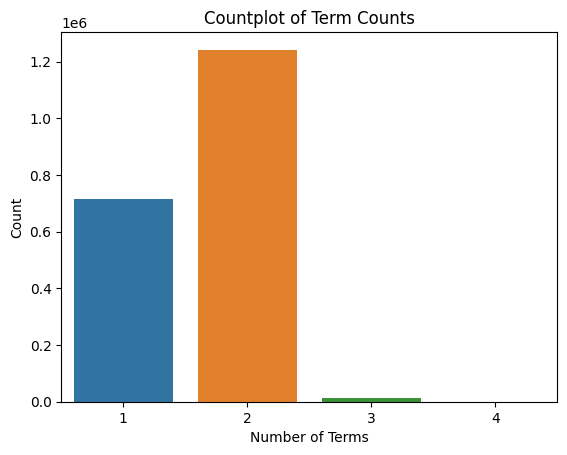

In [41]:
# Plotting the countplot
sns.countplot(data=lab_results_df, x='Term counts')

# Adding labels and title
plt.xlabel('Number of Terms')
plt.ylabel('Count')
plt.title('Countplot of Term Counts')

# Display the countplot
plt.show()

In [42]:
# Define the desired term count value
desired_term_count = 4

# Create a new DataFrame with rows where 'Term counts' equals the desired value
term_counts_df = lab_results_df[lab_results_df['Term counts'] == desired_term_count].copy()

term_counts_df

,Unnamed: 0,Internalpatientid,Age at lab test,Lab test date,Lab test,Lab test description,Result numeric,Result textual,Result range,Result units,Term counts,Specimen source,State
11971,1421707,51456,64.24,2013-08-06 15:57:36.0,egfr-aa_ml/min/1.73/m2_plasma,EGFR-AA,51.00,NaN,NaN,mL/min/1.73/m2,4,plasma,West Virginia
11973,1421709,51456,64.24,2013-08-06 15:57:36.0,egfr-naa_ml/min/1.73/m2_plasma,EGFR-NAA,44.00,NaN,NaN,mL/min/1.73/m2,4,plasma,West Virginia
12024,1421760,51456,69.62,2018-12-27 12:29:26.0,egfr-aa_ml/min/1.73/m2_plasma,EGFR-AA,31.00,NaN,NaN,mL/min/1.73/m2,4,plasma,West Virginia
12026,1421762,51456,69.62,2018-12-27 12:29:26.0,egfr-naa_ml/min/1.73/m2_plasma,EGFR-NAA,26.00,NaN,NaN,mL/min/1.73/m2,4,plasma,West Virginia
465235,74735079,6318,85.24,2004-05-30 01:41:49.0,"protein, 24 hr calc_mg/ 24 hr_no specimen","PROTEIN, 24 HR CALC",231.52,NaN,0 - 150,mg/ 24 hr,4,NaN,Florida
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1969957,328702627,51456,65.19,2014-07-21 02:09:26.0,egfr-aa_ml/min/1.73/m2_plasma,EGFR-AA,NaN,>60,NaN,mL/min/1.73/m2,4,plasma,West Virginia
1970384,328831436,51456,64.36,2013-09-19 04:03:31.0,egfr-aa_ml/min/1.73/m2_plasma,EGFR-AA,NaN,>60,NaN,mL/min/1.73/m2,4,plasma,West Virginia
1970388,328831440,51456,64.36,2013-09-19 04:03:31.0,egfr-naa_ml/min/1.73/m2_plasma,EGFR-NAA,NaN,>60,NaN,mL/min/1.73/m2,4,plasma,West Virginia
1970397,328831449,51456,66.94,2016-04-20 08:03:53.0,egfr-aa_ml/min/1.73/m2_plasma,EGFR-AA,NaN,>60,NaN,mL/min/1.73/m2,4,plasma,West Virginia


In [43]:
term_counts_df['Result units'].unique()

array(['mL/min/1.73/m2', 'mg/ 24 hr', '10 3 /UL', 'mL/min/1.73 m2',
       'L/min OR %', 'mm/hour//', 'nM BCE/mM Cr', 'x10 to 6/L',
       '/100 WBC %', 'mg Al/g Cr', 'mg AL/g CR'], dtype=object)

In [44]:
len(term_counts_df['Result units'].unique())

11

# Determining Top 90% of Conditions

In [45]:
conditions_df = df_list[3]
conditions_df

,Unnamed: 0,Internalpatientid,Age at condition documentation,Condition documented date,Condition type,Condition code icd10 subcategory,Diagnosis sequence number or rank,State
0,587,100012,52.02,2001-07-09 02:42:14.0,Diagnosis,Encounter for attention to tracheostomy,P,Texas
1,588,100012,52.10,2001-08-06 18:37:42.0,Diagnosis,Essential (primary) hypertension,P,Texas
2,589,100012,52.10,2001-08-06 18:37:42.0,Diagnosis,Benign prostatic hyperplasia,S,Texas
3,590,100012,52.34,2001-11-01 08:08:08.0,Diagnosis,Encounter for examination and observation for ...,P,Texas
4,591,100012,52.59,2002-02-03 09:02:55.0,Diagnosis,"Encounter for administrative examinations, uns...",P,New Mexico
...,...,...,...,...,...,...,...,...
655303,112203098,99944,72.10,2004-08-12 12:48:10.0,Diagnosis,Essential (primary) hypertension,P,Massachusetts
655304,112203099,99944,77.94,2010-06-15 11:38:02.0,Problem,Calculus of kidney,NaN,Massachusetts
655305,112203100,99944,78.21,2010-09-24 02:23:05.0,Diagnosis,Not specified,P,Massachusetts
655306,112203101,99944,80.44,2012-12-16 02:26:00.0,Diagnosis,"Heart failure, unspecified",P,Massachusetts


In [51]:
conditions_df.nunique()

Unnamed: 0                           655308
Internalpatientid                      1000
Age at condition documentation       655265
Condition documented date            314029
Condition type                            2
Condition code icd10 subcategory       4144
Diagnosis sequence number or rank        27
State                                    50
dtype: int64

In [52]:
conditions_df['Condition code icd10 subcategory'].value_counts()

Essential (primary) hypertension                      31153
Type 2 diabetes mellitus without complications        20948
Not specified                                         16914
Encounter for other specified aftercare               16414
Unspecified atrial fibrillation and atrial flutter    14807
                                                      ...  
Sex counseling, unspecified                               1
Other disorders of globe                                  1
Osteitis condensans                                       1
Acquired deformity of chest and rib                       1
Counseling related to sexual attitude                     1
Name: Condition code icd10 subcategory, Length: 4144, dtype: int64

In [56]:
value_counts = conditions_df['Condition code icd10 subcategory'].value_counts()
# Step 2: Calculate the cumulative sum of the frequencies
cumulative_sum = value_counts.cumsum()

# Step 3: Find the threshold value that represents the top 90% of the data
threshold = cumulative_sum.max() * 0.9

# Step 4: Select the values that make up the top 90% of the data
top_values = value_counts[cumulative_sum <= threshold]

# Step 5: Create a dataframe with the top values
top_values_df = pd.DataFrame({'Top Values': top_values.index, 'Frequency': top_values.values})

top_values_df

,Top Values,Frequency
0,Essential (primary) hypertension,31153
1,Type 2 diabetes mellitus without complications,20948
2,Not specified,16914
3,Encounter for other specified aftercare,16414
4,Unspecified atrial fibrillation and atrial flu...,14807
...,...,...
609,Other specified follicular disorders,133
610,Other specified aplastic anemias and other bon...,132
611,Alcoholic cardiomyopathy,132
612,"Dermatophytosis, unspecified",131


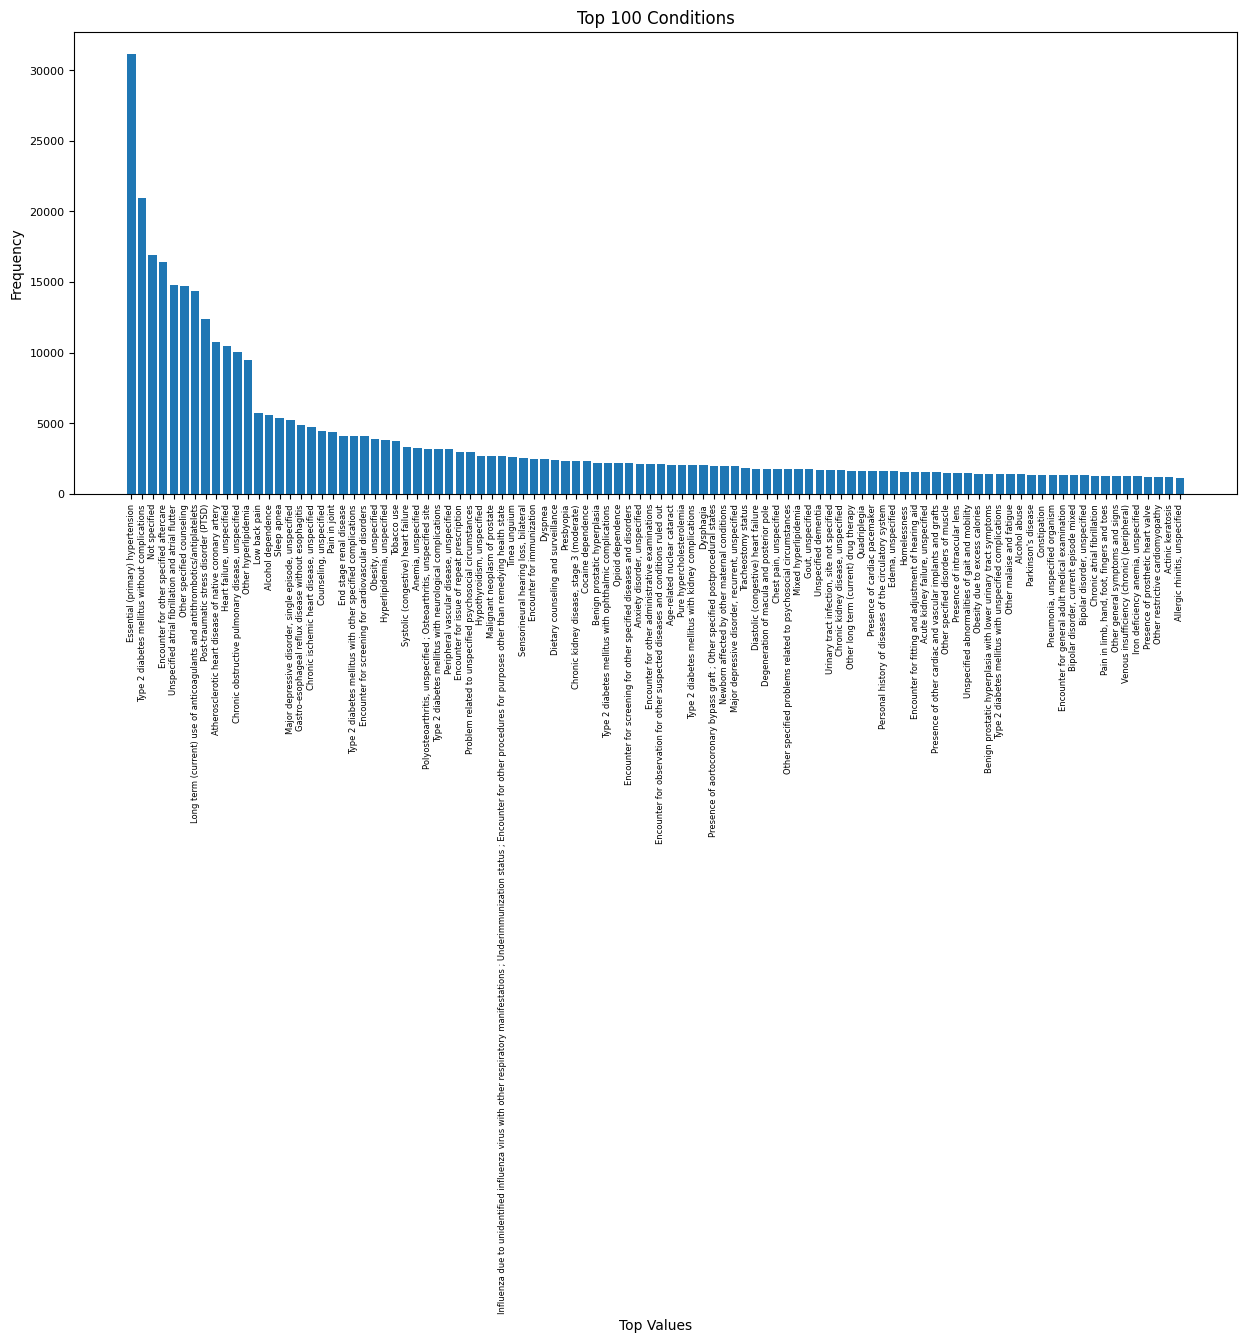

In [66]:
top_100_results = top_values_df.head(100)

# Plot the top 100 results in a bar plot
plt.figure(figsize=(15, 6))
plt.bar(top_100_results['Top Values'], top_100_results['Frequency'])
plt.xticks(rotation=90, fontsize=8)  # Adjust the fontsize as desired
plt.yticks(fontsize=8)  # Adjust the fontsize as desired
plt.xticks(fontsize=6)  # Adjust the fontsize as desired
plt.xlabel('Top Values', fontsize=10)  # Adjust the fontsize as desired
plt.ylabel('Frequency', fontsize=10)  # Adjust the fontsize as desired
plt.title('Top 100 Conditions', fontsize=12)  # Adjust the fontsize as desired
plt.show()

In [67]:
# Specify the file path where you want to save the .csv file
file_path = '/content/drive/MyDrive/top_90_percent_conditions.csv'

# Save the dataframe to a .csv file
top_values_df.to_csv(file_path, index=False)

# Responses for Vital Signs

In [46]:
vitals_df = df_list[13]
vitals_df

,Unnamed: 0,Internalpatientid,Age at measurement,Measurement date,Measurement,Result numeric,Result textual,State
0,581,100012,52.87,2002-05-15 18:48:46.0,Pulse,86.00,NaN,New Mexico
1,582,100012,52.87,2002-05-15 18:48:46.0,Weight,387.47,NaN,New Mexico
2,583,100012,52.87,2002-05-15 18:48:46.0,Blood pressure,NaN,135/81,New Mexico
3,584,100012,52.87,2002-05-15 18:48:46.0,Respiratory rate,20.00,NaN,New Mexico
4,585,100012,52.87,2002-05-15 18:48:46.0,Pain,2.00,NaN,New Mexico
...,...,...,...,...,...,...,...,...
1069996,159912291,99944,80.63,2013-02-24 10:06:41.0,Blood pressure,NaN,116/60,Massachusetts
1069997,159912292,99944,80.63,2013-02-24 10:06:41.0,Temperature,100.00,NaN,Massachusetts
1069998,159912293,99944,80.63,2013-02-24 10:06:41.0,Pulse oximetry,98.00,NaN,Massachusetts
1069999,159912294,99944,80.63,2013-02-24 10:06:41.0,Pulse,60.00,NaN,Massachusetts


In [48]:
vitals_df.nunique()

Unnamed: 0            1070001
Internalpatientid         994
Age at measurement    1069950
Measurement date       278637
Measurement                10
Result numeric         160236
Result textual           8475
State                      50
dtype: int64

In [50]:
vitals_df['Measurement'].value_counts()

Pain                       204430
Blood pressure             196502
Pulse                      189484
Respiratory rate           151794
Temperature                145612
Pulse oximetry              99653
Weight                      59962
Height                      21820
Circumference/girth           508
Central venous pressure       236
Name: Measurement, dtype: int64

In [68]:
# Calculate the value counts
measurement_counts = vitals_df['Measurement'].value_counts()

# Convert the Series to a DataFrame
measurement_counts_df = measurement_counts.to_frame().reset_index()

# Rename the columns in the DataFrame
measurement_counts_df.columns = ['Measurement', 'Count']

measurement_counts_df

,Measurement,Count
0,Pain,204430
1,Blood pressure,196502
2,Pulse,189484
3,Respiratory rate,151794
4,Temperature,145612
5,Pulse oximetry,99653
6,Weight,59962
7,Height,21820
8,Circumference/girth,508
9,Central venous pressure,236


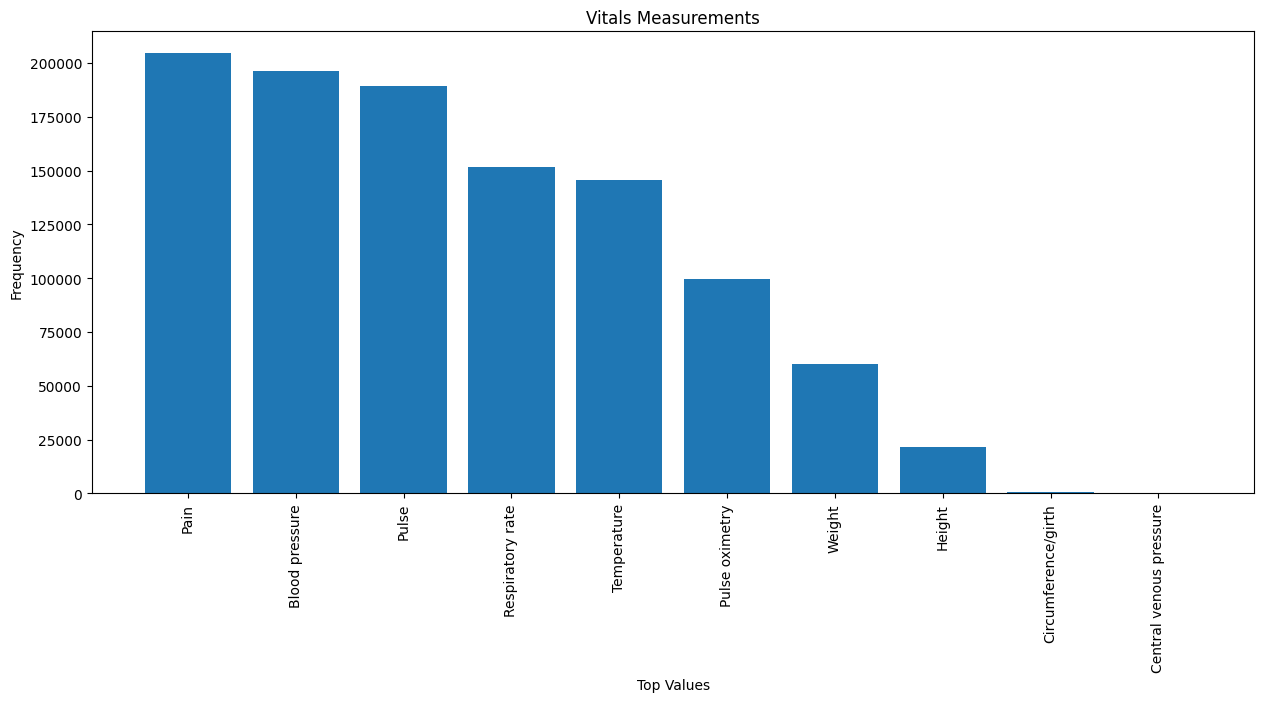

In [72]:
# Plot the top 100 results in a bar plot
plt.figure(figsize=(15, 6))
plt.bar(measurement_counts_df['Measurement'], measurement_counts_df['Count'])
plt.xticks(rotation=90, fontsize=8)  # Adjust the fontsize as desired
plt.yticks(fontsize=10)  # Adjust the fontsize as desired
plt.xticks(fontsize=10)  # Adjust the fontsize as desired
plt.xlabel('Top Values', fontsize=10)  # Adjust the fontsize as desired
plt.ylabel('Frequency', fontsize=10)  # Adjust the fontsize as desired
plt.title('Vitals Measurements', fontsize=12)  # Adjust the fontsize as desired
plt.show()

In [69]:
# Specify the file path where you want to save the .csv file
file_path = '/content/drive/MyDrive/vitals.csv'

# Save the dataframe to a .csv file
measurement_counts_df.to_csv(file_path, index=False)